In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import optimize


# Combining Kd's
Tip: Skip to the end for a tldr. 

Ligand species, arising from protonation or tautomer states, will often bind with different Kd's (dissociation constant) to a target of interest. How does this affect your observed Kd in experiment? More to the point: If I predict that one protomer of a ligand is very potent, how much do I downweight that prediction when I learn that the protomer is very rare? 

There are (at least) three papers that suggest how to do this:
- Combining protomer energies was implemented in FEP+ in [this Schrodinger paper](https://doi.org/10.1021/acs.jctc.8b00826), equation 4. That derivation may well be correct, but the math is missing a step for me so I don't want to use it.
- [This paper](https://doi.org/10.1021/ct1002913), equation 22, deals with combining Kd's from multiple conformations on the _protein_ side (for a single ligand species), by summing the equilibrium binding constants for each conformation, each being weighted by the population of that conformation.
- Finally, [this article](https://pubmed.ncbi.nlm.nih.gov/23170882/) presents a "master equation" that governs the contributions of all ligand _and_ protein species (protomers, tautomers, and conformations), along with their binding modes. The derivation seems clearer to me - it's a big, messy equation but made of little, easier pieces. And it seems to match the previous derivations to my eye. So let's use this one.

The 'master equation', equation 2, looks like this:

![img](https://ljmartin.github.io/data/combiki.png)

where ijk is ligand i, receptor j, binding mode k, square brackets are concentrations, and 'f' is the fraction of unbound ligand and receptor. K is the _association_ constant, so that's 1/Kd. This equation suggests we can calculate the observed association constants 'k' by summing all the sub-k's, weighted by the fractional population in solution of that species (before binding).

# Validation by simulation
We can't validate this 'master equation' theory by experiment, because it's impossible to isolate a ligand species, such as a tautomer, to measure its Kd individually and then apply the equation to compare with the observed Kd from the mixture. We only have access to that observed Kd (measured using the mixture of species). Nevertheless, more than 50 years ago [Martin and Hansch](https://pubmed.ncbi.nlm.nih.gov/5140003/) were seeing implicit experimental support for this equation when they tried incorporating the fraction of charged ligand species into their pioneering QSAR models.

Instead of experimental observation, let's settle for a numerical simulation using ordinary differential equations! In such a simulation, we can set the on- and off-rates of every reversible reaction, and that means we can directly observe the species' concentrations as they reach equilibrium. 

To keep things manageable, this simulation will model the concentrations of a ligand with two tautomers, complexing with a single protein conformation. For the ligand, we start by equilibrating the tautomer populations to arrive at the two free fraction values (f). We can also equilibrate a mixture of the ligand tautomers and the protein to arrive at an observered Kd. Since we know all the on-rates and off-rates, we can calculte association constants (k) for each species individually. Then we can predict the observed Kd using the master equation (the 'f's and the 'k's), and see if the values match up. 

In a little more detail:
- Using an ODE, we can simulate the % of free ligand, free protein, and bound complex that is implied by a reversible reaction `P+L<->PL`
- Likewise, we can simulate the % of tautomer species in the same way, where the reversible reaction is `L1<->L2`
- Likewise, we can simulate the % of each unbound and bound tautomer species to a protein, `P+L1+L2<->PL1+L2<->PL1+PL2<->PL2+L1`. In practice we only care about `PL1+PL2`, because that's what is measurable in a real experiment, i.e. it represents the combined, observed, Kd
- To set up these simulations, we have to input an on-rate and an off-rate for each process. Since the equilibrium binding constant is just on-rate/off-rate, we know the individual Kd's of each ligand species in this simulation, so we know exactly how to generate a combined Kd using the master equation.
- After the simulation of the protein and the ligand species mixture, we can then fit a kinetic model to the signal from the combined `PL1+PL2`, as you might do in an experiment, to generate the "experimental" apparent Kd. 
- Finally, we can compare the apparent Kd (from our simulated 'experimental' data) to the predicted combined Kd (from the master equation) and see if the two match up. 

# Start with the tautomers
To make the master equation work, we'd need the tautomer transition reaction to happen much faster than the protein complexation process. For many tautomers of interest, this is a plausible assumption (see the paper). In this case, I set the forward and reverse-rates of the tautomer transition to lead to ~95% tautomer 1, and ~5% tautomer 2, while both being pretty fast. 

The cell below generates an equilibrated solution of the tautomers by starting from an equal mixture (impossible to realise in practice) and then waiting 2 seconds. You can see that the rates are reasonably fast because the equilibration happens in <1s. 

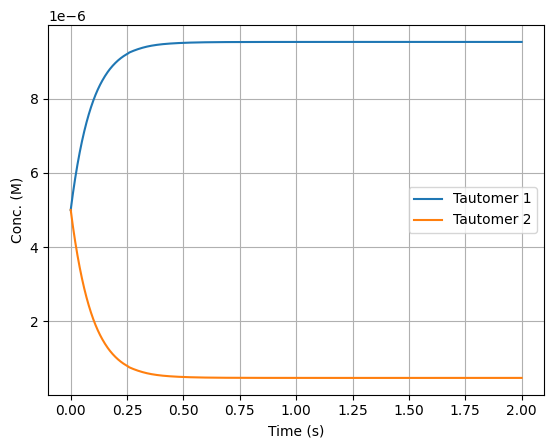

In [2]:
#ODE:
def rate_equations(y, t, k_tau1, k_tau2):
    L1, L2 = y  # concentrations
    # rate updates:

    #rate tautomer 1 per time:
    dL1dt = k_tau2 * L2 - k_tau1 * L1

    #rate tautomer 2 per time:
    dL2dt = k_tau1 * L1 - k_tau2 * L2 
    
    return [dL1dt, dL2dt]

# initialise concentrations to some starting value:
L1_0 = 5e-6  # 5 μM
L2_0 = 5e-6  # 5 μM

# set some rates for the tautomer transition:
k_tau1 = 0.5   # in M^-1 s^-1 #this could be considered the off-rate
k_tau2 = 10  # in s^-1 #which makes this the on-rate. Remember the reaction is reversible
             # so on- and off-rates both happen at same time. Molar Units in the 'on' rate are a convention.
# Initial conditions
y0 = [L1_0, L2_0]

# Time points for the simulation
t = np.linspace(0, 2, 1000)  # 2 second simulation. It's fast, so 2s is all we need!

# Integrate the rate equations
y = odeint(rate_equations, y0, t, args=(k_tau1, k_tau2))

# Extract the concentrations
L1 = y[:, 0]
L2 = y[:, 1]
plt.plot(t, L1, label='Tautomer 1')
plt.plot(t, L2, label='Tautomer 2')
plt.legend()
plt.ylabel('Conc. (M)')
plt.xlabel('Time (s)')
plt.grid()

Let's plot it as % populations instead. At equilibrium, these % populations are also known as the 'f' values of each tautomer. 


(0.0, 100.0)

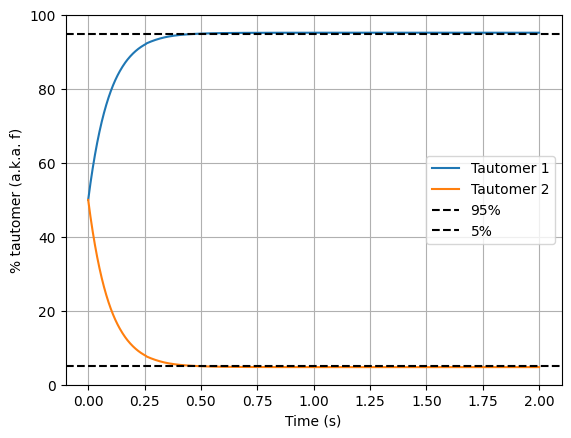

In [3]:
plt.plot(t, L1/(L1+L2)*100, label='Tautomer 1')
plt.plot(t, L2/(L1+L2)*100, label='Tautomer 2')
plt.axhline(95, c='k', linestyle='--', label='95%')
plt.axhline(5, c='k', linestyle='--', label='5%')

plt.legend()
plt.ylabel('% tautomer (a.k.a. f)')
plt.xlabel('Time (s)')

plt.grid()
plt.ylim(0, 100)

In [4]:
#calculate the fraction of each tautomer in the equilibrated state.

# Note: This is the "f" value that we will use in the master equation!!
# e.g. f1 = fraction of tautomer 1 in the solvated state. 

f1 = L1[-1]/(L1[-1]+L2[-1])
f2 = L2[-1]/(L1[-1]+L2[-1])

print('Equilibrium fraction of tautomer 1:', f1)
print('Equilibrium fraction of tautomer 2:', f2)

Equilibrium fraction of tautomer 1: 0.9523869293511661
Equilibrium fraction of tautomer 2: 0.04761307064883393


# Now move to a tautomer + protein simulation. 
To make the protein-binding simulation work, we'll first need to think up some on-rates and off-rates for the complexation of tautomer 1 with protein, and separately the complexation of tautomer 2 with protein. Both of these will be evolving at the same time. 

I purposely set these on- and off-rates so that tautomer 2, which is the minor tautomer, is much more potent. The point of this is to simulate the question about down-weighting our Kd predictions if the predicted ligand is a minor tautomer. 

Looking at [the affinity plot on SPRPages](https://www.sprpages.nl/troubleshooting/high-affinity), these rate values are pretty realistic for a real small molecule ligand of interest. 

Note the printed Ki's after the cell. These are:
- 1 µMolar
- 5 nanoMolar

In [5]:
# set some protein equilibrium binding constants using on and off rates:
# Rate constants

#tautomer 1 binding to protein:
k_on1 = 1e3    #  M^-1 s^-1
k_off1 = 1e-3     # s^-1

#tautomer 2 binding to protein:
k_on2 = 2e5    # M^-1 s^-1
k_off2 = 1e-3  # s^-1

# So now we can calculate the true equilibrium binding constants. Important step!
# these are assocation constants btw. K_eq, not Kd. 
true_taut1_k_eq = (k_on1/k_off1)
true_taut2_k_eq = (k_on2/k_off2)

# and so these are the true Kd's (it's just 1/K_eq)
true_taut1_kd = 1/true_taut1_k_eq
true_taut2_kd = 1/true_taut2_k_eq
print('K_i for tautomer 1 (in Molar):', true_taut1_kd)
print('K_i for tautomer 2 (in Molar):', true_taut2_kd)


K_i for tautomer 1 (in Molar): 1e-06
K_i for tautomer 2 (in Molar): 5e-09


# Run the protein-binding simulation using the pre-equilibrated tautomer mixture. 

Note that we now have the true values for the association constants (and thus dissociation constants) for the two tautomer species. We also have the 'f' values for the ligands. So we _could_ apply the master equation now. But first I want to get an intuitive feel for things by running another model and plotting the concentrations of free ligand, free protein, and complexes.  

This is pretty much the same as the tautomer situation, however the ODE equation is a little bit more involved in order to handle two different ligand-protein binding processes at the same time as regeneration of the tautomer populations amongst the unbound fraction!

In [6]:
# Define the rate equations
def rate_equations(y, t, k_on1, k_off1, k_on2, k_off2, k_tau1, k_tau2):
    P, L1, L2, PL1, PL2 = y  # concs
    # rates equations:

    # change in conc of protein wrt time
    dPdt = -k_on1 * P * L1 + k_off1 * PL1 - k_on2 * P * L2 + k_off2 * PL2

    # change in conc of ligand tautomer 1 wrt time:
    dL1dt = -k_on1 * P * L1 + k_off1 * PL1 + k_tau2 * L2 - k_tau1 * L1

    # change in conc of ligand tautomer 2 wrt time:
    dL2dt = -k_on2 * P * L2 + k_off2 * PL2 + k_tau1 * L1 - k_tau2 * L2

    # change in conc of protein complexed with ligand tautomer 1:
    dPL1dt = k_on1 * P * L1 - k_off1 * PL1

    # change in conc of protein complexed with ligand tautomer 2:
    dPL2dt = k_on2 * P * L2 - k_off2 * PL2    
    
    return [dPdt, dL1dt, dL2dt, dPL1dt, dPL2dt]
    # whew.

# Initial concentrations
P0 = 100e-6    # 100 μM of protein. I guess this is much larger than what typically is used in experiment.
L1_0 = L1[-1]  # take the equilibrated conc of ligand tautomer 1 from the previous simulation
L2_0 = L2[-1]  # ditto for tautomer 2

PL1_0 = 0 # we start with zero concentration of bound protein to tautomer 1`
PL2_0 = 0 # ditto for tautomer 2

# Initial conditions
y0 = [P0, L1_0, L2_0, PL1_0, PL2_0]

# Time points for the simulation
t = np.linspace(0, 30, 5000)  # 30 second simulation. It's equilibrated in about 15s.

# Integrate the rate equations
y = odeint(rate_equations, y0, t, args=(k_on1, k_off1, k_on2, k_off2, k_tau1, k_tau2))

# Extract the concentrations
P = y[:, 0]
L1 = y[:, 1]
L2 = y[:, 2]
PL1 = y[:, 3]
PL2 = y[:, 4]

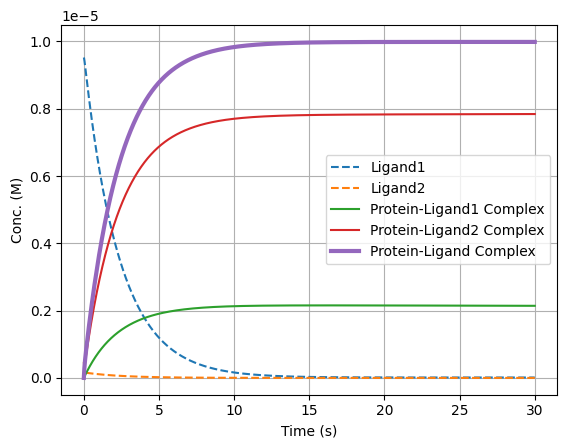

In [7]:
# Plot the concentrations over time
#plt.plot(t, P, label='Protein')
plt.plot(t, L1, linestyle='--', label='Ligand1')
plt.plot(t, L2, linestyle='--', label='Ligand2')
plt.plot(t, PL1, label='Protein-Ligand1 Complex')
plt.plot(t, PL2, label='Protein-Ligand2 Complex')
plt.plot(t, PL1+PL2, linewidth=3, label='Protein-Ligand Complex')

plt.xlabel('Time (s)')
plt.ylabel('Conc. (M)')
plt.grid()
plt.legend()
plt.show()

notice how the Protein-Ligand2 complex (red) ends up being higher than the Protein-Ligand1 complex (green), even though tautomer 1 is ~19X more abundant! This is because tautomer 1 is much less potent, so it's bound fraction is smaller. 

but what we really care about is the total amount of complexed protein in purple, which is the sum of PL1 and PL2, because that's what we would observe experimentally. That is, the purple line is how we calculate our observed, Kd in the lab. In lieu of doing the IRL experiment, we can infer the on- and off-rates in reverse, kind of like if this was an SPR sensorgram. Then we find our observed K_eq as `observed on-rate / observed off-rate`.

Practically, this is achieved by fitting an ODE model with scipy.optimize to the purple curve. We change the ODE to assume there is a single ligand species, because in experiment we can only observe a single readout, and wouldn't know the concentrations of each ligand species i.e. the we fit an ODE model that assumes `P+L<->PL`. This resembles what people do every day when screening compounds that might have tautomers or protonation states or, indeed, proteins with more than one conformation. We always just assume it's a single protein and single ligand, and we always measure the 'observed' equilibrium state, which is a smoosh of all binding modes, protomers and conformations. 

In [8]:
# the ODE for our single-protein, single-ligand model (P+L<->PL)
def rate_equations(y, t, k_on, k_off):
    P, L, PL = y  # concs
    
    # rate updates:
    dPdt = -k_on * P * L + k_off * PL
    dLdt = -k_on * P * L + k_off * PL
    dPLdt = k_on * P * L - k_off * PL
    
    return [dPdt, dLdt, dPLdt]
    

and now, to fitting the observed concentration curve to estimate the correct rates, as you would do in experiment. Note that I first tried scipy.optimize.minimize but the gradient was too flat in the precision range. I found that the 'DIRECT' algorithm available in scipy.optimize finds a solution quickly, is consistent over time, and doesn't take long to complete. I guess it is gradient-free so it doesn't get stuck.

In [9]:
#this is our target data, it's the observed "PL" in P+L<->PL
observed = np.array(PL1+PL2)

def fitting_function(pars):
    """
    This is a loss function for a given set of on-rate and off-rates
    The on-rate and off-rate are in logspace, allowing the model to fit 
    more smoothly. So the first step is to transform back to linear space. 
    """
    k_on, k_off = pars
    k_on = 10**k_on # transform to linear space
    k_off = 10**k_off # transform to linear space
    #P0 = ...#already been set.
    PL0 = 0
    L0 = L1_0+L2_0 #already been set. It's the sum of equilibrated L1 and L2 populations.
    
    y0 = [P0, L0, PL0]
    #generate a simulated curve.
    y = odeint(rate_equations, y0, t, args=(k_on, k_off))

    #see how closely this curve matches the observed data. 
    rmse = ((y[:,-1]-observed)**2).sum()
    return rmse


# I put in some sensible bounds on the rates, using the sprpages graph linked above. 

res = optimize.direct(fitting_function,maxfun= 5_000,
                      bounds=[(1,9), 
                             (-6,1)]
                      )
res

 message: Number of function evaluations done is larger than maxfun=5000
 success: False
  status: 1
     fun: 2.1740294333618713e-12
       x: [ 3.653e+00 -3.299e+00]
     nit: 271
    nfev: 5013

OK the loss is very small, so our observed, apparent, P+L<->PL system must be pretty close to the simulated ligand species' kinetics model. 

So we can calculate the observed Kd, and this would be a reasonable simulation of our belief about the Kd in a real life experiment. 

First let's just plot the overlap of the equilibration process to make doubly sure:

In [10]:
res.x

array([ 3.6532315 , -3.29852326])

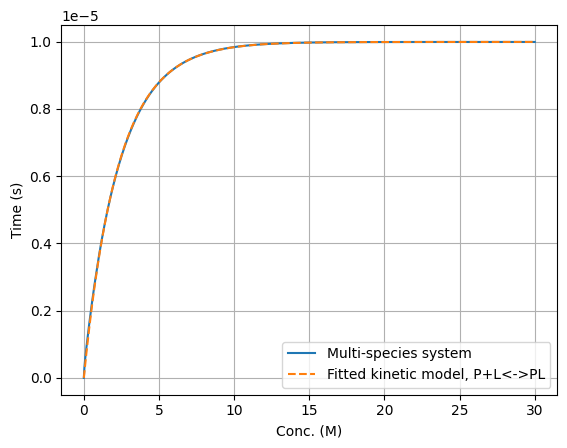

In [11]:
k_on, k_off = res.x
k_on = 10**k_on # transform to linear space
k_off = 10**k_off # transform to linear space 
#P0 = ...#already set.
PL0 = 0
L0 = L1_0+L2_0
y0 = [P0, L0, PL0]

y = odeint(rate_equations, y0, t, args=(k_on, k_off))

plt.plot(t, observed, label="Multi-species system")
plt.plot(t, y[:,-1], linestyle='--', label='Fitted kinetic model, P+L<->PL')
plt.xlabel('Conc. (M)')
plt.ylabel('Time (s)')
plt.legend()
plt.grid()

after all that, this is our apparent Kd from our 'experiment', in Molar:

In [12]:
observed_kd = 1/(k_on/k_off)
print(observed_kd)

1.1174941097085943e-07


# now compare our observed Ki to the master equation Kd.

the master equation says we sum the equilibrium binding constants of the ligand species, weighted by their fraction in the unbound population.

i.e. `K_eq = f1*keq1 + f2*keq2 + ....`

In [13]:
#combined K_eq:

true_k_eq = f1 * true_taut1_k_eq + f2 * true_taut2_k_eq

# convert to K_i:
true_kd = 1/true_k_eq
true_kd

9.546538414232915e-08

the master equation says our combined Kd should be something like 95 nM. Note that this is a pretty big drop from the true Ki of tautomer 2, which was 5 nM, but it's also substantially _better_ than our tautomer 1, whch was 5 µM!

In [14]:
print("Combined Kd using the master equation method, in µM:")
print(np.around(true_kd*1e6, 4))
print("Observed Kd by fitting an ODE model, in µM:")
print(np.around(observed_kd*1e6, 4))

Combined Kd using the master equation method, in µM:
0.0955
Observed Kd by fitting an ODE model, in µM:
0.1117


In [15]:
print('Fractional difference in master equation to our observed Kd:')
observed_kd/true_kd

Fractional difference in master equation to our observed Kd:


1.17057519827556

pretty close! the master equation and our experimental observed Kd were within about 20%.

finally: we didn't need to go to all the trouble of fitting the on-rate/off-rates to get a K_eq, but it's fun because that's what you might do in SPR. In a biochemical experiment we might also just measure the equilibrium state concentrations - because K_eq is also `[P][L]/[PL]` at equilibrium. Here's the easy way:

In [16]:

final_state = y[-1]
observed_kd = (final_state[0]*final_state[1]) / (final_state[2])

print("Combined Ki using the master equation method, in µM:")
print(np.around(true_kd*1e6, 4))
print("Observed Ki by fitting an ODE model, in µM:")
print(np.around(observed_kd*1e6, 4))

Combined Ki using the master equation method, in µM:
0.0955
Observed Ki by fitting an ODE model, in µM:
0.1076


it's actually a bit closer :)

In [17]:
print('Fractional difference in master equation to our observed Ki:')
observed_kd/true_kd

Fractional difference in master equation to our observed Ki:


1.1268707523301031

# conclusion. 

so it looks like the master equation is pretty good. If it's a simulation, with no noise, why doesn't it agree perfectly? It's not clear whether the simulation is imperfect (certainly plausible) or whether the master equation is imperfect (seems fine to me), _or_ if the assumptions I made about kinetic rates mean the applicability domain is a bit off.

And, to answer my own question: If I predicted a ligand is very potent, but it was a minor tautomer, then it's probably not a huge deal if it's at least a 1-in-20 occupancy tautomer. 

# tldr; how to use this:
if you don't care for the modelling aspect, here's a quick heuristic using orders of magnitude. Let's use the situation where you have one active tautomer/protomer of interest at 50 nM, and the other one is functionally inactive - let's call it 500 µM. For most populations for tautomer 1 (the 'f' value), your observed potency is going to be _pretty_ close to 50 nM. It's only once you get to about ~10% occupancy of the potent tautomer that you lose a full log unit of potency. And, when you get to ~1% occupancy you lose another log. So it's more or less powers of ten.   

the same math works for a single protein species binding to an active conformation of a protein that is only 10% populated, or 1%, and so on...

In [18]:
true_taut1_kd = 50/1e9
true_taut2_kd = 500/1e6

f1 = 0.9 #lots of the potent tautomer. observed Ki should be a little bit worse than 50 nM. 
f2 = 1-f2

keq = f1*(1/true_taut1_kd) + f1*(1/true_taut2_kd)
print('Observed Ki:', np.around(-np.log10(1/keq), 3, ))


Observed Ki: 7.255


In [19]:
f1 = 0.1 # 1 in 10 ratio of potent tautomer. observed Ki should be near 500 nM. 
f2 = 1-f1

keq = f1*(1/true_taut1_kd) + f1*(1/true_taut2_kd)
print('Observed Ki:', np.around(-np.log10(1/keq), 3, ))


Observed Ki: 6.301


In [20]:
f1 = 0.01 # 1 in 100 ratio of potent tautomer. Observed Ki should be about 5 µM
f2 = 1-f1

keq = f1*(1/true_taut1_kd) + f1*(1/true_taut2_kd)
print('Observed Ki:', np.around(-np.log10(1/keq), 3, ))


Observed Ki: 5.301


K_i for tautomer 1 (in Molar): 5e-08
K_i for tautomer 2 (in Molar): 0.0005


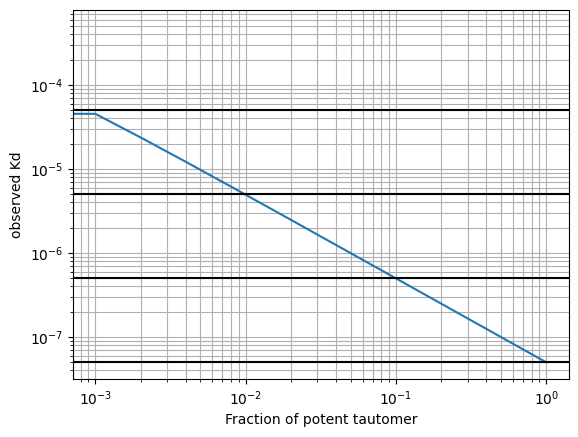

In [21]:
from scipy.special import logit, expit
print('K_i for tautomer 1 (in Molar):', true_taut1_kd)
print('K_i for tautomer 2 (in Molar):', true_taut2_kd)

kiqs = []
xs = []
for x in np.linspace(0, 1, 1000):
    y = 1-x
    keq = x*(1/true_taut1_kd) + y*(1/true_taut2_kd)
    kiq = 1/keq
    kiqs.append(kiq)
    xs.append(x)

plt.plot(xs, kiqs)
plt.yscale('log',)
plt.axhline(50/1e9, c='k')
plt.axhline(50/1e8, c='k')
plt.axhline(50/1e7, c='k')
plt.axhline(50/1e6, c='k')
plt.grid(which='both')
plt.xlabel('Fraction of potent tautomer')
plt.ylabel('observed Kd')
plt.title('')
plt.xscale('log')